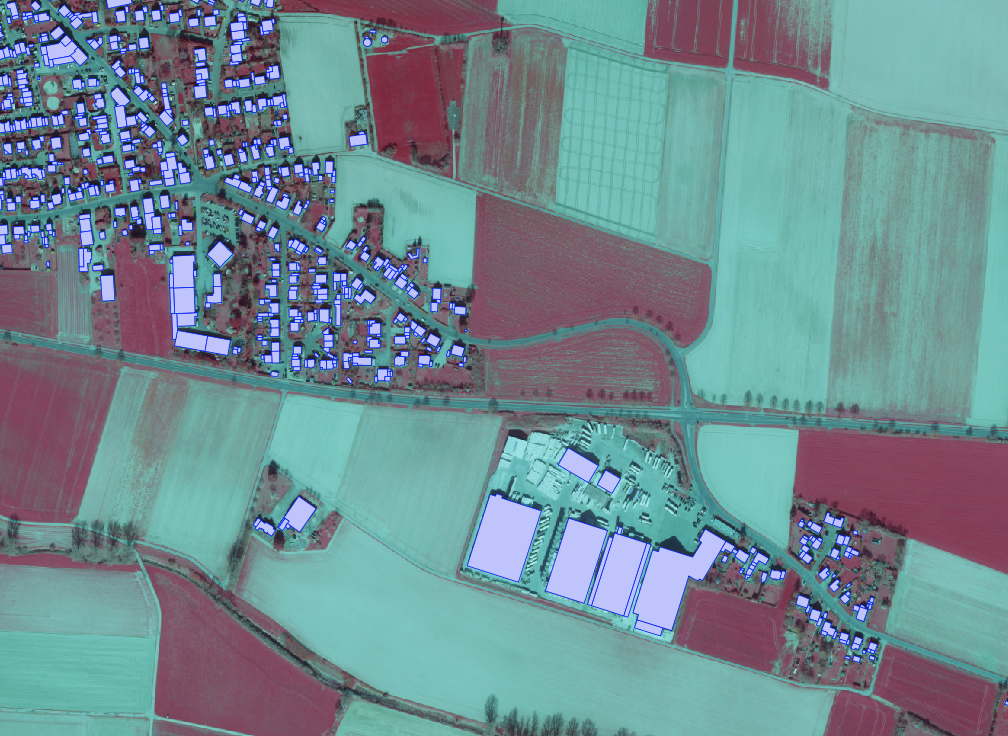

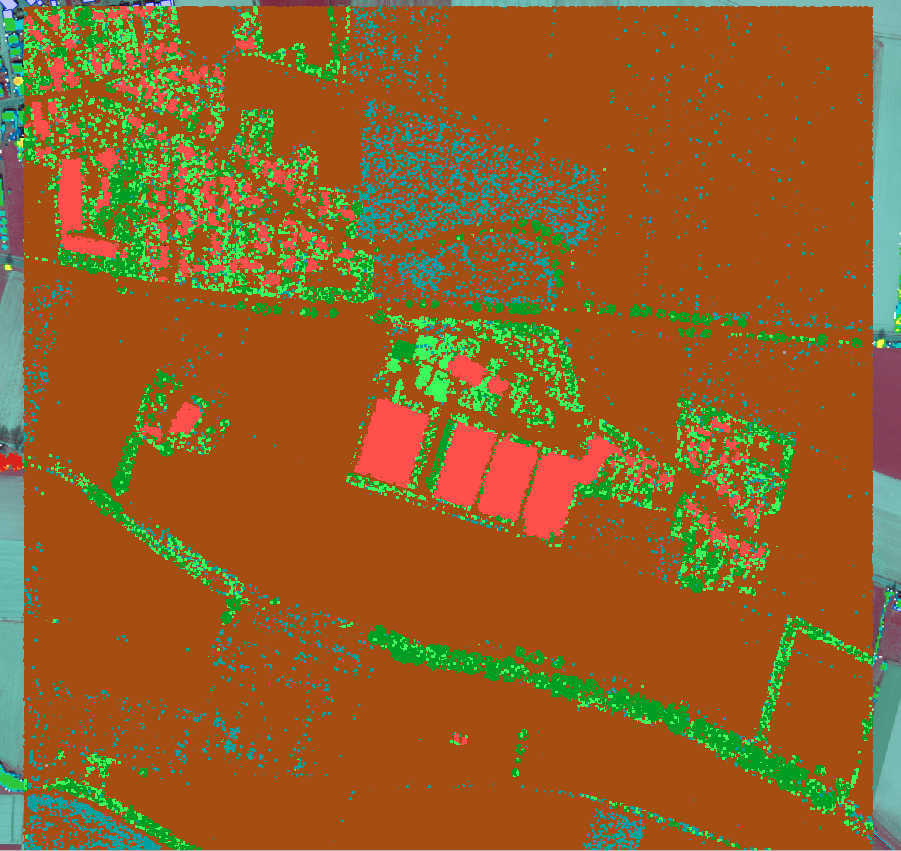

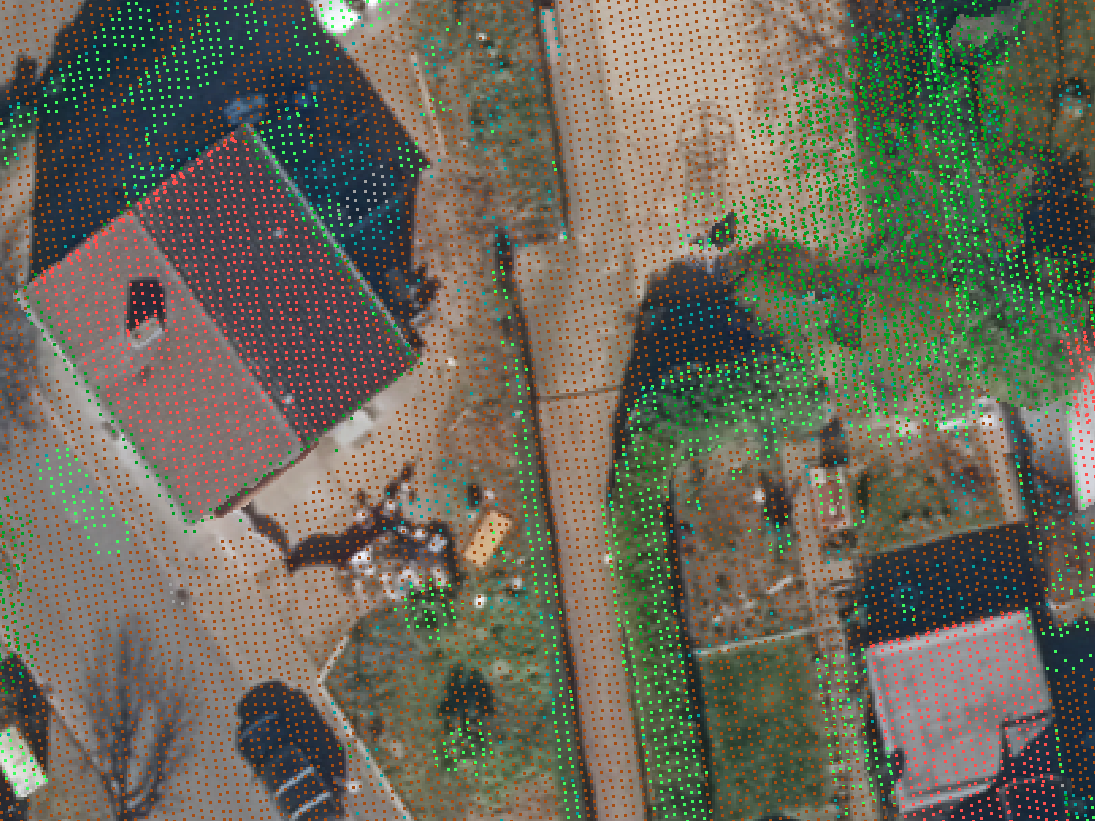

38.699997
Original tiff:


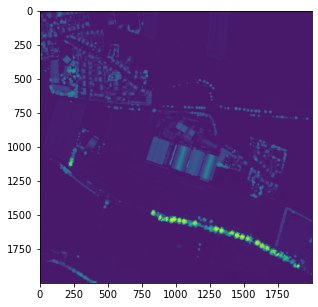

Theshold= 30
Geglättet:


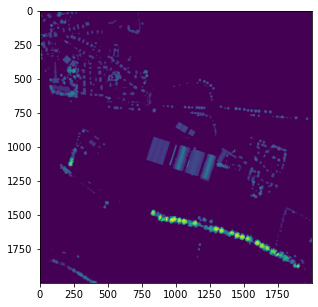

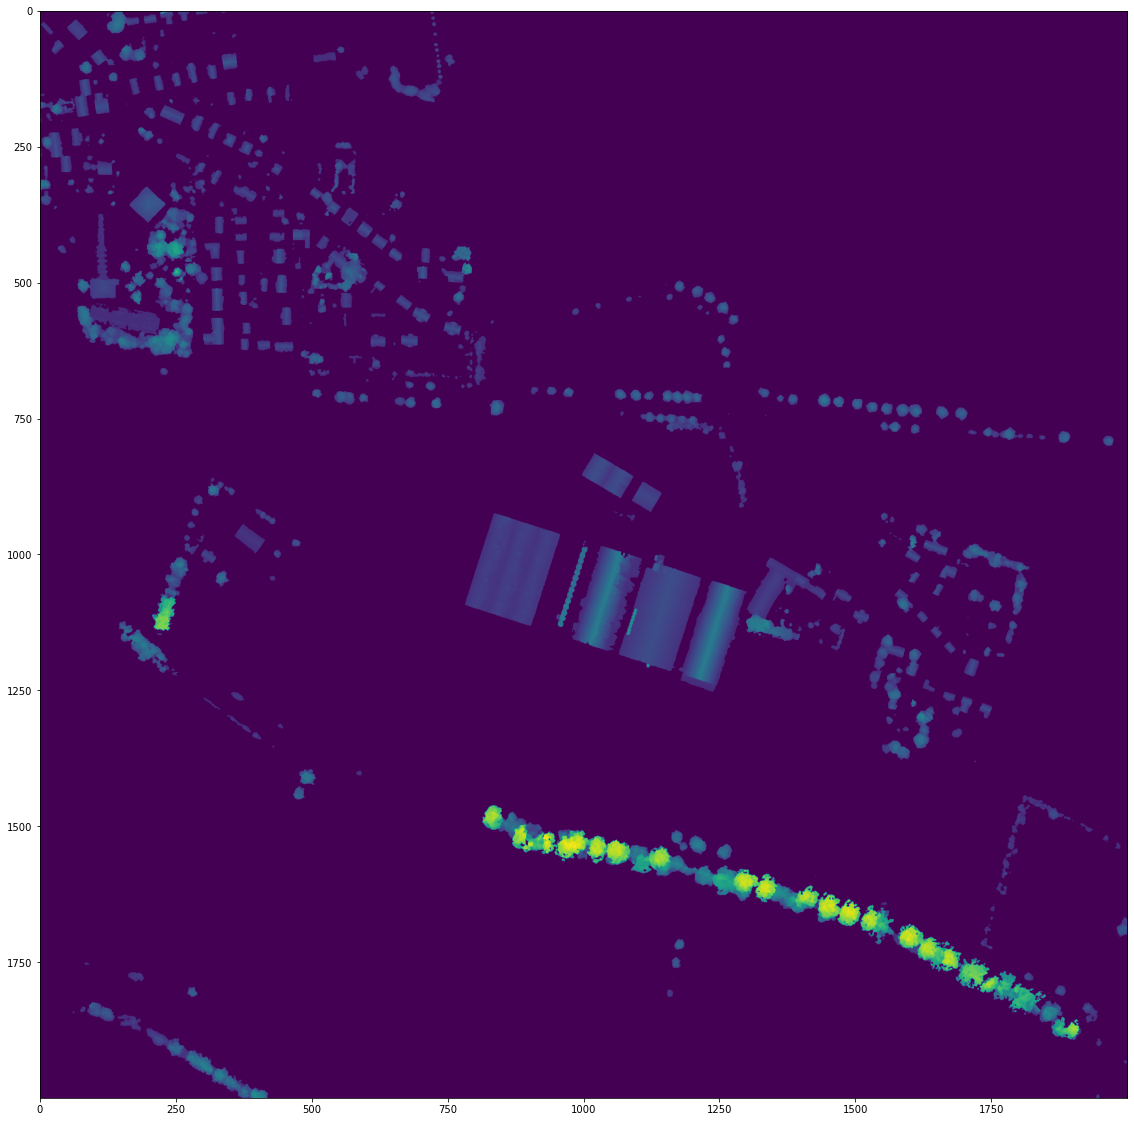

In [1]:
from scipy import ndimage as ndi
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import img_as_float
from PIL import Image
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import numpy
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  
from tqdm import tqdm
#ganz schlecht klassifiziet:3dm_32_330_5726_1_nw.las

las_files=["11_perc_3dm_32_330_5723_1_nw.las", "3dm_32_331_5722_1_nw.las","3dm_32_338_5725_1_nw.las", "3dm_32_337_5727_1_nw.las", "3dm_32_337_5726_1_nw.las","3dm_32_337_5725_1_nw.las"]
folder = "lidar-files/test"
las_file = folder+ "/" + las_files[0]

#setze größe der geplotteten bilder:
plt.rcParams['figure.figsize'] = [5, 5]

#lade bild als numpy.array
bdom_file = "ndom50_32330_5723_1_nw_2018.tif"
im = numpy.array(Image.open(bdom_file))
#scaliere in pixel-werte größer 0
m = - numpy.min(im)
#im = im + m

#scaliere in range(0,255) und als integer-array:
m = numpy.max(im)
print(m)
im = ((im/m) *255).astype(numpy.int32)

print("Original tiff:")
plt.imshow(im)
plt.show()

#setze alle pixelwerte < thresshold = 0, um den boden zu glätten
#sonst werden bei jeder kleinen bodenwelle lokale maxima gefunden
threshhold =30 #(numpy.max(im) + numpy.min(im)) * 0.03
print("Theshold=", threshhold)
im = numpy.where(im > threshhold, im, 0) # 0.3,
print("Geglättet:")

plt.imshow(im)
plt.show()
##gaussischer filter (falsch!):
#print("Weichzeichnen:")
#im = gaussian_filter(im, sigma=3)
#median filter
im = median_filter(im, size=3)


#setze größe der geplotteten bilder:
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(im)
plt.show()


#43 Bäume laut kataster


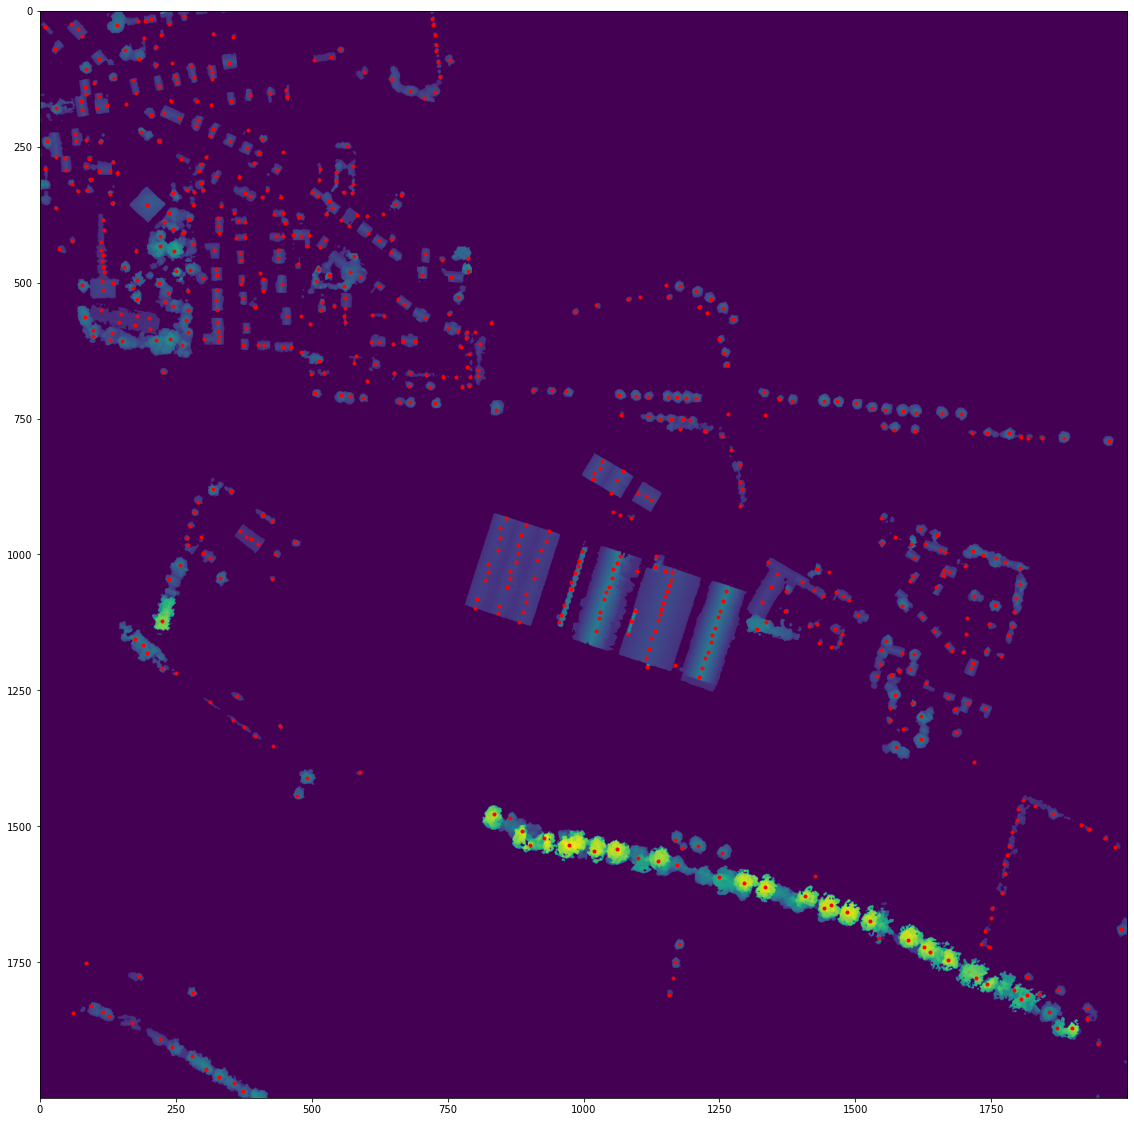

Anzahl Maxima: 700


In [2]:
#wenn hier die maxima im einfarbigen bereich auftauchen, ist der threshold oben zu niedrig
#hier kann über den min-distance-wert skaliert werden:

min_distance = 10 # 8<= x  <= 15

#image_max = ndi.maximum_filter(im, size=1)   #, mode='constant'
# Comparison between image_max and im to find the coordinates of local maxima
coordinates = []
# https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.peak_local_max :
coordinates = peak_local_max(im, min_distance=min_distance)


plt.imshow(im)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
plt.show()
print("Anzahl Maxima:", len(coordinates))

In [3]:
import laspy

las = laspy.read(las_file)



In [4]:
las_points_x = numpy.array(las.points['x']) 
las_points_y = numpy.array(las.points['y'])
x_max, x_min, y_max, y_min = las_points_x.max(),  las_points_x.min(), las_points_y.max(),  las_points_y.min()
x_range = x_max - x_min
y_range = y_max - y_min
print(x_max, x_min,x_range, y_max, y_min, y_range)

331000.01 329999.98 1000.0300000000279 5724000.01 5722999.98 1000.0299999993294


In [5]:
import pandas

#koordinaten vom geotiff  bestimmen - > utm koodinate jedes pixels ableiten  - > die coordiates-liste umrechnen 
#- > nächste punkte bestimmen
#load metadata csv
meta_data = pandas.read_csv("metadata/ndom_nw.csv", sep=";")
kachelname = bdom_file.split("/")[-1].split(".")[0]
row = meta_data.loc[meta_data['Kachelname'] == kachelname]

#cpnvert coordinates to ut coords_
x_pixels, y_pixels = im.shape[1],im.shape[0]
step = row['Aufloesung_cm'].values[0]/100  #0.5m per pixel!
utm_coordinates = numpy.zeros((len(coordinates), 2))
for i in range(len(utm_coordinates)):
    utm_coordinates[i][0] = coordinates[i][1] * step + x_min
    utm_coordinates[i][1] = y_max - coordinates[i][0] * step


In [6]:
#check utm_coordinates:
import folium
import coord_f
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',



lat,long = coord_f.utm_to_lat_long(x_max, y_max)
lat_min,long_min = coord_f.utm_to_lat_long(x_min, y_min)

f_map = folium.Map(location=[lat, long], zoom_start=14)
#add las area:
folium.Marker(location=[lat, long],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long],icon=folium.Icon(color="red")).add_to( f_map )

latlong_coordinates = list(map(coord_f.utm_to_lat_long, list(zip(*utm_coordinates))[0],  list(zip(*utm_coordinates))[1]))
#add trees:
for lat, long in latlong_coordinates:
    folium.Marker(location=[lat, long],icon=folium.Icon(color="green")).add_to( f_map )

f_map

In [7]:
from sklearn.cluster import DBSCAN
length = len(las.points['x'])

points_to_cluster = numpy.array([[las.points['x'][i], las.points['y'][i], las.points['z'][i]] for i in tqdm(range(length)) if (las.points['classification'][i] == 5)]) 
indices_of_cluster_points = numpy.array([i for i in tqdm(range(length)) if (las.points['classification'][i] == 5)]) 
cluster = DBSCAN(eps=1, min_samples=10).fit(points_to_cluster)  # parameters according to https://www.degruyter.com/document/doi/10.1515/geo-2020-0266/html?lang=de
labels = cluster.labels_
for i, l in tqdm(zip(indices_of_cluster_points, labels)):
    if l == -1:
        las.points['classification'][i] = 1 



100%|██████████| 9805369/9805369 [02:04<00:00, 78992.43it/s]
915917it [00:01, 495978.77it/s]


In [8]:
from scipy.spatial import distance
#find list of nearest points in las:    
centroids_in_las = numpy.zeros((len(utm_coordinates), 3))
z =numpy.max(numpy.array(las.points['z']))

las_points = numpy.array((las.points['x'], las.points['y'],las.points['z'])).transpose()  #hier noch nach classification filtern!
print(las_points)
for i in tqdm(range(len(utm_coordinates) -1, -1, -1 )):
        coord = [utm_coordinates[i][0], utm_coordinates[i][1], z]
        closest_index = int(distance.cdist([coord], las_points).argmin())
        c = las.points['classification'][closest_index]
        if c in [5]:
            centroids_in_las[i] = las.points['x'][closest_index], las.points['y'][closest_index], las.points['z'][closest_index]
        else:
            centroids_in_las = numpy.delete(centroids_in_las, i,  axis=0)

print(len(centroids_in_las))

[[3.30009520e+05 5.72300011e+06 1.57100000e+01]
 [3.30010200e+05 5.72300016e+06 1.55700000e+01]
 [3.30016270e+05 5.72300019e+06 1.55100000e+01]
 ...
 [3.30999830e+05 5.72399955e+06 2.00900000e+01]
 [3.30999030e+05 5.72399962e+06 2.00700000e+01]
 [3.30999510e+05 5.72399873e+06 2.01000000e+01]]


100%|██████████| 700/700 [01:01<00:00, 11.42it/s]

342


In [9]:
lat,long = coord_f.utm_to_lat_long(x_max, y_max)
lat_min,long_min = coord_f.utm_to_lat_long(x_min, y_min)

f_map = folium.Map(location=[lat, long], zoom_start=14)
#add las area:
folium.Marker(location=[lat, long],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long],icon=folium.Icon(color="red")).add_to( f_map )

latlong_coordinates = list(map(coord_f.utm_to_lat_long, list(zip(*centroids_in_las))[0],  list(zip(*centroids_in_las))[1]))
#add trees:
for lat, long in latlong_coordinates:
    folium.Marker(location=[lat, long],icon=folium.Icon(color="green")).add_to( f_map )

f_map

0 Nie klassifiziert
1 Nicht zugewiesen
2 Oberfläche
3 Niedrige Vegetation
4 Mittelhohe Vegetation
5 Hohe Vegetation
6 Gebäude
7 Tiefpunkt
8 Reserviert
9 Wasser
10 Schienen
11 Straßenbelag
12 Reserviert
13 Schutzdraht (Schild)
14 Drahtleiter (Phase)
15 Strommast
16 Leitungsverbinder (Isolator)
17 Brückenfahrbahn
18 Hohes Rauschen

In [10]:
import clustering
used_classifications = [5]
points_to_cluster = numpy.array([[las.points['x'][i], las.points['y'][i], las.points['z'][i]] for i in tqdm(range(len(las.points['x']))) if (las.points['classification'][i] in used_classifications)]) 
#geht das mit fiter vielleicht schneller? 1:30 ist viel zu langsam..

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


100%|██████████| 9805369/9805369 [02:17<00:00, 71091.69it/s]


In [11]:
#print(centroids_in_las)
print(points_to_cluster)

kmeans= clustering.k_means_no_dbscan(centroids_in_las, points_to_cluster, 1)

[[3.30159640e+05 5.72301368e+06 2.09100000e+01]
 [3.30160000e+05 5.72301335e+06 2.10800000e+01]
 [3.30157060e+05 5.72301998e+06 1.89600000e+01]
 ...
 [3.30986520e+05 5.72360312e+06 2.50100000e+01]
 [3.30986620e+05 5.72360364e+06 2.54700000e+01]
 [3.30986410e+05 5.72360347e+06 2.83900000e+01]]
starting k-means:
finish!


In [12]:
labels = kmeans.labels_
cluster_dict = {}
for i in range(max(labels) +1):
    cluster_dict[i] = []
for i, p in tqdm(zip(labels, points_to_cluster)):
    cluster_dict[i] =  cluster_dict[i] + [p]


846625it [00:07, 109384.56it/s]


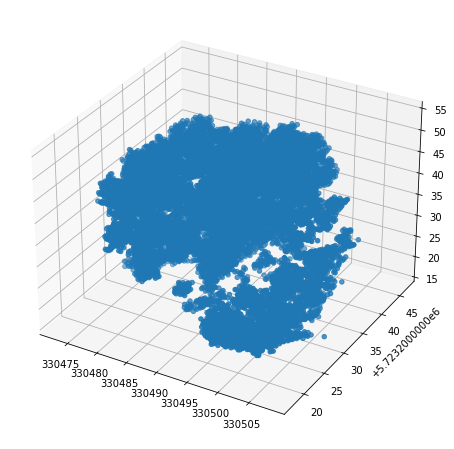

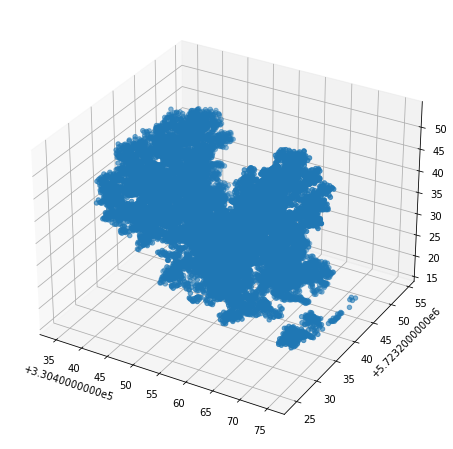

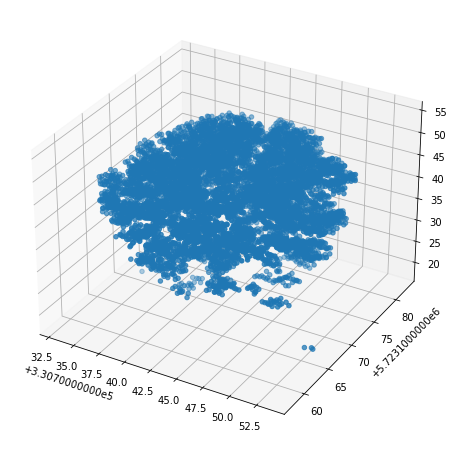

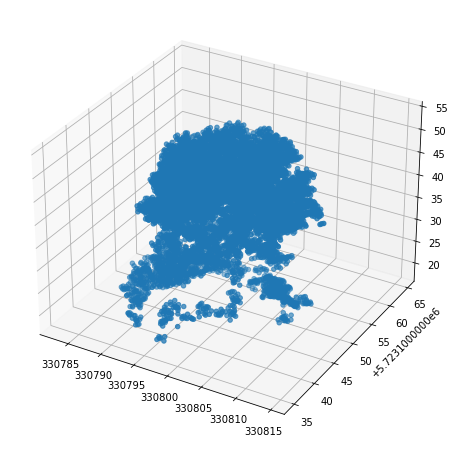

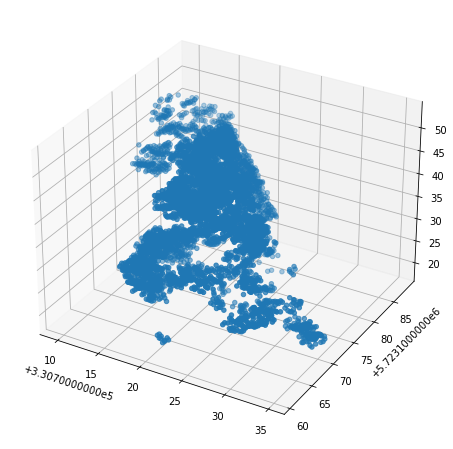

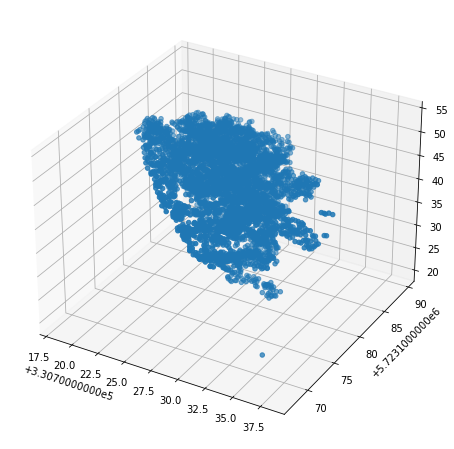

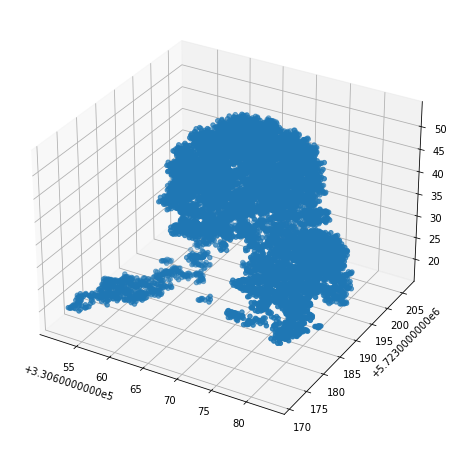

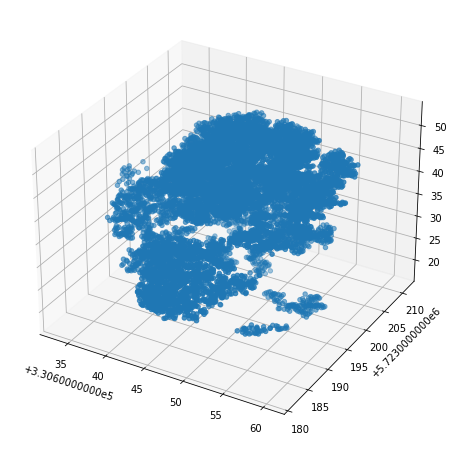

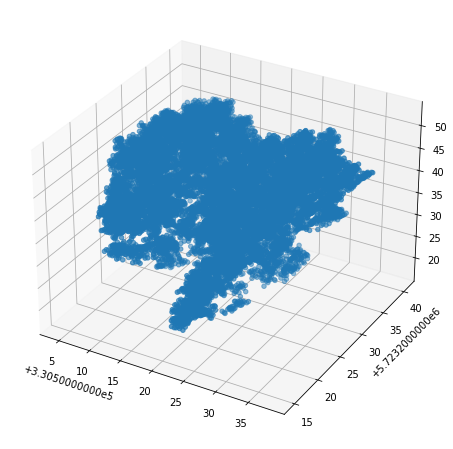

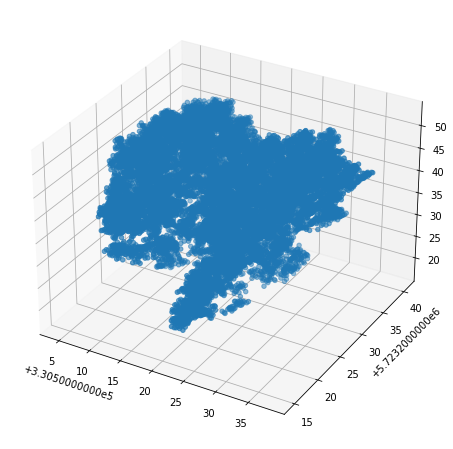

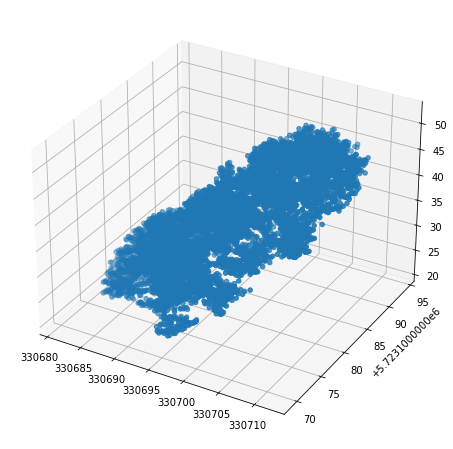

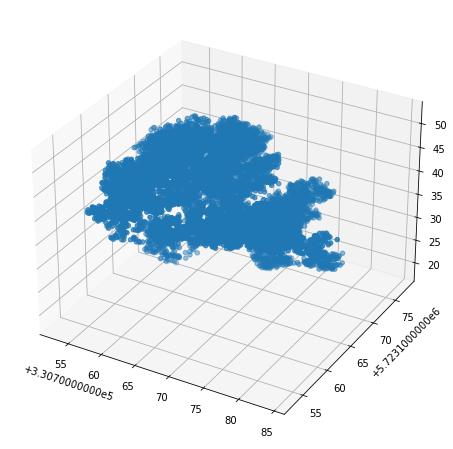

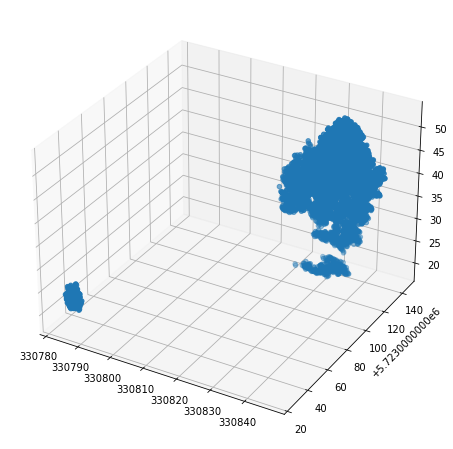

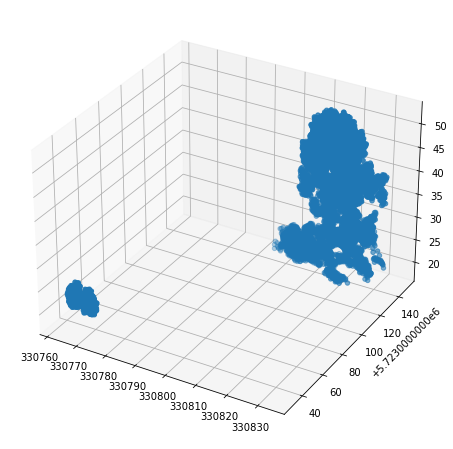

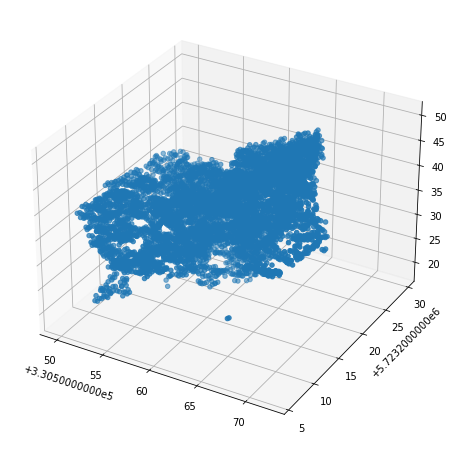

In [13]:
# plot one cluster:
#print(cluster_dict[0])
for i in [0,1,2,3,4,5,6,7,8, 8, 9,10,11,12,13]:
    points = cluster_dict[i]
    #MultiPoint(points)
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    z = [point[2] for point in points]

    #plt.scatter(xs, ys)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z)
    plt.show()

In [14]:
"""connected_cluster_dict = {}
for val in cluster_dict.values():
    small_clusters = DBSCAN(eps=3, min_samples=1).fit(val)  # parameters according to https://www.degruyter.com/document/doi/10.1515/geo-2020-0266/html?lang=de
    labels = small_clusters.labels_

    
    tree = numpy.array(val).transpose((1, 0))
    x = tree[0]
    y = tree[1] 
    points_2d = numpy.array([x,y]).transpose()

    if len(points_2d) > 50:
        hull = ConvexHull(points_2d)
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))

        for ax in (ax1, ax2):
            ax.plot(points_2d[:, 0], points_2d[:, 1], '.')
            if ax == ax1:
                ax.set_title('Given points')
            else:
                ax.set_title('Convex hull')
                for simplex in hull.simplices:
                    ax.plot(points_2d[simplex, 0], points_2d[simplex, 1], 'c')
                ax.plot(points_2d[hull.vertices, 0], points_2d[hull.vertices, 1], 'o', mec='r', color='none', lw=1, markersize=10)
        plt.show()
        print((numpy.array(labels).max() +1))
""" 

"connected_cluster_dict = {}\nfor val in cluster_dict.values():\n    small_clusters = DBSCAN(eps=3, min_samples=1).fit(val)  # parameters according to https://www.degruyter.com/document/doi/10.1515/geo-2020-0266/html?lang=de\n    labels = small_clusters.labels_\n\n    \n    tree = numpy.array(val).transpose((1, 0))\n    x = tree[0]\n    y = tree[1] \n    points_2d = numpy.array([x,y]).transpose()\n\n    if len(points_2d) > 50:\n        hull = ConvexHull(points_2d)\n        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))\n\n        for ax in (ax1, ax2):\n            ax.plot(points_2d[:, 0], points_2d[:, 1], '.')\n            if ax == ax1:\n                ax.set_title('Given points')\n            else:\n                ax.set_title('Convex hull')\n                for simplex in hull.simplices:\n                    ax.plot(points_2d[simplex, 0], points_2d[simplex, 1], 'c')\n                ax.plot(points_2d[hull.vertices, 0], points_2d[hull.vertices, 1], 'o', mec='r', color='non

In [33]:
#x/y-convex hull
hull_dict = {}
for i in range(max(labels) +1):
    tree = numpy.array(cluster_dict[i]).transpose((1, 0))
    x = tree[0]
    y = tree[1]    
    points_2d = numpy.array([x,y]).transpose()
    if len(points_2d) > 50:
        hull = ConvexHull(points_2d)
        """
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))

        for ax in (ax1, ax2):
            ax.plot(points_2d[:, 0], points_2d[:, 1], '.', color='k')
            if ax == ax1:
                ax.set_title('Given points')
            else:
                ax.set_title('Convex hull')
                for simplex in hull.simplices:
                    ax.plot(points_2d[simplex, 0], points_2d[simplex, 1], 'c')
                ax.plot(points_2d[hull.vertices, 0], points_2d[hull.vertices, 1], 'o', mec='r', color='none', lw=1, markersize=10)
        plt.show()
        """
        print(points_2d[hull.vertices])
        hull_dict[i] = Polygon(points_2d[hull.vertices])

    

[[ 330475.37 5723244.63]
 [ 330472.8  5723231.19]
 [ 330473.26 5723225.21]
 [ 330474.32 5723223.67]
 [ 330480.1  5723217.67]
 [ 330480.44 5723217.59]
 [ 330480.74 5723217.55]
 [ 330482.15 5723217.4 ]
 [ 330496.03 5723217.97]
 [ 330499.22 5723218.23]
 [ 330503.3  5723218.86]
 [ 330503.74 5723219.  ]
 [ 330505.65 5723221.25]
 [ 330508.01 5723228.95]
 [ 330507.34 5723238.38]
 [ 330498.1  5723245.8 ]
 [ 330494.02 5723246.2 ]
 [ 330488.71 5723246.67]
 [ 330483.24 5723246.87]
 [ 330479.39 5723246.87]
 [ 330477.93 5723246.61]
 [ 330477.06 5723246.28]]
[[ 330459.16 5723252.83]
 [ 330451.74 5723254.35]
 [ 330449.18 5723253.69]
 [ 330443.83 5723251.23]
 [ 330441.48 5723247.92]
 [ 330439.83 5723245.25]
 [ 330436.26 5723238.27]
 [ 330435.75 5723236.9 ]
 [ 330434.81 5723233.95]
 [ 330434.73 5723233.1 ]
 [ 330434.88 5723232.28]
 [ 330436.39 5723230.34]
 [ 330445.17 5723226.56]
 [ 330447.22 5723225.9 ]
 [ 330463.45 5723224.16]
 [ 330463.82 5723224.14]
 [ 330468.06 5723225.27]
 [ 330471.48 5723227.75]

[[ 330266.1  5723296.88]
 [ 330251.66 5723321.86]
 [ 330250.48 5723322.47]
 [ 330247.86 5723323.04]
 [ 330247.07 5723322.45]
 [ 330245.19 5723320.97]
 [ 330244.71 5723320.35]
 [ 330239.17 5723304.46]
 [ 330238.71 5723297.93]
 [ 330238.98 5723291.06]
 [ 330240.16 5723290.11]
 [ 330241.21 5723289.5 ]
 [ 330243.35 5723288.46]
 [ 330243.77 5723288.28]
 [ 330244.08 5723288.17]
 [ 330245.04 5723287.98]
 [ 330252.04 5723287.41]
 [ 330252.44 5723287.61]
 [ 330265.82 5723295.33]]
[[ 330715.1  5723642.12]
 [ 330714.91 5723640.51]
 [ 330715.6  5723638.82]
 [ 330715.85 5723638.37]
 [ 330716.7  5723636.9 ]
 [ 330718.57 5723635.9 ]
 [ 330720.6  5723635.04]
 [ 330721.27 5723635.1 ]
 [ 330721.92 5723635.19]
 [ 330724.07 5723635.79]
 [ 330724.46 5723636.07]
 [ 330725.65 5723637.14]
 [ 330725.91 5723641.1 ]
 [ 330725.92 5723641.92]
 [ 330725.77 5723642.53]
 [ 330725.68 5723642.77]
 [ 330724.65 5723645.22]
 [ 330724.62 5723645.29]
 [ 330724.38 5723645.69]
 [ 330721.96 5723647.42]
 [ 330721.33 5723647.66]

[[ 330348.66 5723654.61]
 [ 330358.35 5723650.26]
 [ 330361.   5723650.54]
 [ 330363.6  5723653.8 ]
 [ 330363.59 5723653.91]
 [ 330363.47 5723654.71]
 [ 330362.04 5723656.41]
 [ 330359.61 5723657.62]
 [ 330351.93 5723661.31]
 [ 330349.81 5723662.16]
 [ 330348.95 5723656.73]
 [ 330348.81 5723655.82]
 [ 330348.76 5723655.42]]
[[ 330251.28 5723644.27]
 [ 330255.03 5723643.3 ]
 [ 330256.07 5723643.38]
 [ 330258.1  5723645.04]
 [ 330258.48 5723645.52]
 [ 330258.58 5723645.67]
 [ 330259.5  5723647.09]
 [ 330257.6  5723650.46]
 [ 330257.23 5723650.85]
 [ 330256.66 5723651.25]
 [ 330255.7  5723651.52]
 [ 330254.36 5723651.62]
 [ 330252.89 5723651.71]
 [ 330249.85 5723649.49]
 [ 330249.65 5723648.68]
 [ 330249.76 5723647.62]
 [ 330249.88 5723646.74]]
[[ 330607.76 5723736.67]
 [ 330608.81 5723738.3 ]
 [ 330609.51 5723741.77]
 [ 330609.68 5723742.81]
 [ 330609.6  5723743.47]
 [ 330609.21 5723744.2 ]
 [ 330607.47 5723746.08]
 [ 330606.84 5723746.4 ]
 [ 330604.28 5723746.79]
 [ 330602.37 5723745.95

[[ 330871.53 5723337.78]
 [ 330863.74 5723363.75]
 [ 330862.08 5723364.09]
 [ 330842.02 5723359.7 ]
 [ 330840.93 5723359.25]
 [ 330830.56 5723344.6 ]
 [ 330830.48 5723344.26]
 [ 330830.32 5723343.39]
 [ 330831.59 5723327.22]
 [ 330831.98 5723325.93]
 [ 330832.21 5723325.21]
 [ 330835.01 5723325.64]
 [ 330836.12 5723325.84]
 [ 330870.81 5723335.5 ]
 [ 330871.11 5723335.62]
 [ 330871.25 5723336.25]
 [ 330871.3  5723336.51]]
[[ 330226.29 5723824.25]
 [ 330225.98 5723824.23]
 [ 330205.57 5723810.82]
 [ 330203.69 5723809.52]
 [ 330203.73 5723806.76]
 [ 330203.95 5723799.59]
 [ 330204.03 5723799.2 ]
 [ 330205.42 5723799.27]
 [ 330231.53 5723802.4 ]
 [ 330231.8  5723802.86]
 [ 330231.87 5723804.15]
 [ 330231.97 5723806.05]
 [ 330232.06 5723807.88]
 [ 330227.74 5723823.76]
 [ 330227.4  5723823.99]]
[[ 330697.56 5723059.38]
 [ 330581.27 5723098.73]
 [ 330580.17 5723098.29]
 [ 330578.97 5723097.65]
 [ 330577.73 5723096.98]
 [ 330576.95 5723096.45]
 [ 330576.23 5723094.52]
 [ 330577.35 5723092.94

In [63]:
#db lockup baumkataster

import db_settings
db =db_settings.db(autocommit=False)

db_file_name = las_file.split('.')[0].split('/')[-1] + '.laz'
db_file_name = db_file_name[8:]
print(db_file_name)
req = """SELECT ID FROM LIDAR.LIDAR_FILES WHERE FILE_NAME = \'"""+db_file_name+"""\'"""
lidar_file_number = db.export_to_pandas(req)

trees =db.export_to_pandas("""SELECT * FROM BAEUME.BAEUME WHERE STADT=""" + str(3)) #+"""and LIDAR_FILE="""+str(lidar_file_number['ID'].values[0])+"""ORDER BY id""")
print(trees)

print(lidar_file_number)


3dm_32_330_5723_1_nw.laz
           ID              X             Y  STADT  GATTUNG  LIDAR_FILE
0       95461  335555.629525  5.726000e+06      3      116         110
1       95463  335548.758934  5.725993e+06      3      116         110
2       95467  335456.277944  5.725556e+06      3       81         110
3       95468  335249.108464  5.725540e+06      3       81         110
4       95470  335278.573820  5.725545e+06      3       81         110
...       ...            ...           ...    ...      ...         ...
13791  109236  337347.729951  5.729250e+06      3       81         132
13792  109237  337350.323836  5.729248e+06      3       81         132
13793  109241  339991.201210  5.726174e+06      3       80         145
13794  109248  336207.601064  5.727646e+06      3       81         121
13795  109251  336213.639298  5.727666e+06      3       81         121

[13796 rows x 6 columns]
   ID
0  58


POLYGON ((330459.16 5723252.83, 330451.74 5723254.35, 330449.18 5723253.69, 330443.83 5723251.23, 330441.48 5723247.92, 330439.83 5723245.25, 330436.26 5723238.27, 330435.75 5723236.9, 330434.81 5723233.95, 330434.73 5723233.1, 330434.88 5723232.28, 330436.39 5723230.34, 330445.17 5723226.560000001, 330447.22 5723225.9, 330463.45 5723224.16, 330463.82 5723224.14, 330468.06 5723225.27, 330471.48 5723227.75, 330473.21 5723230.67, 330473.38 5723231.49, 330473.65 5723233.08, 330473.69 5723233.33, 330475.13 5723243.38, 330475 5723244.4, 330459.16 5723252.83))


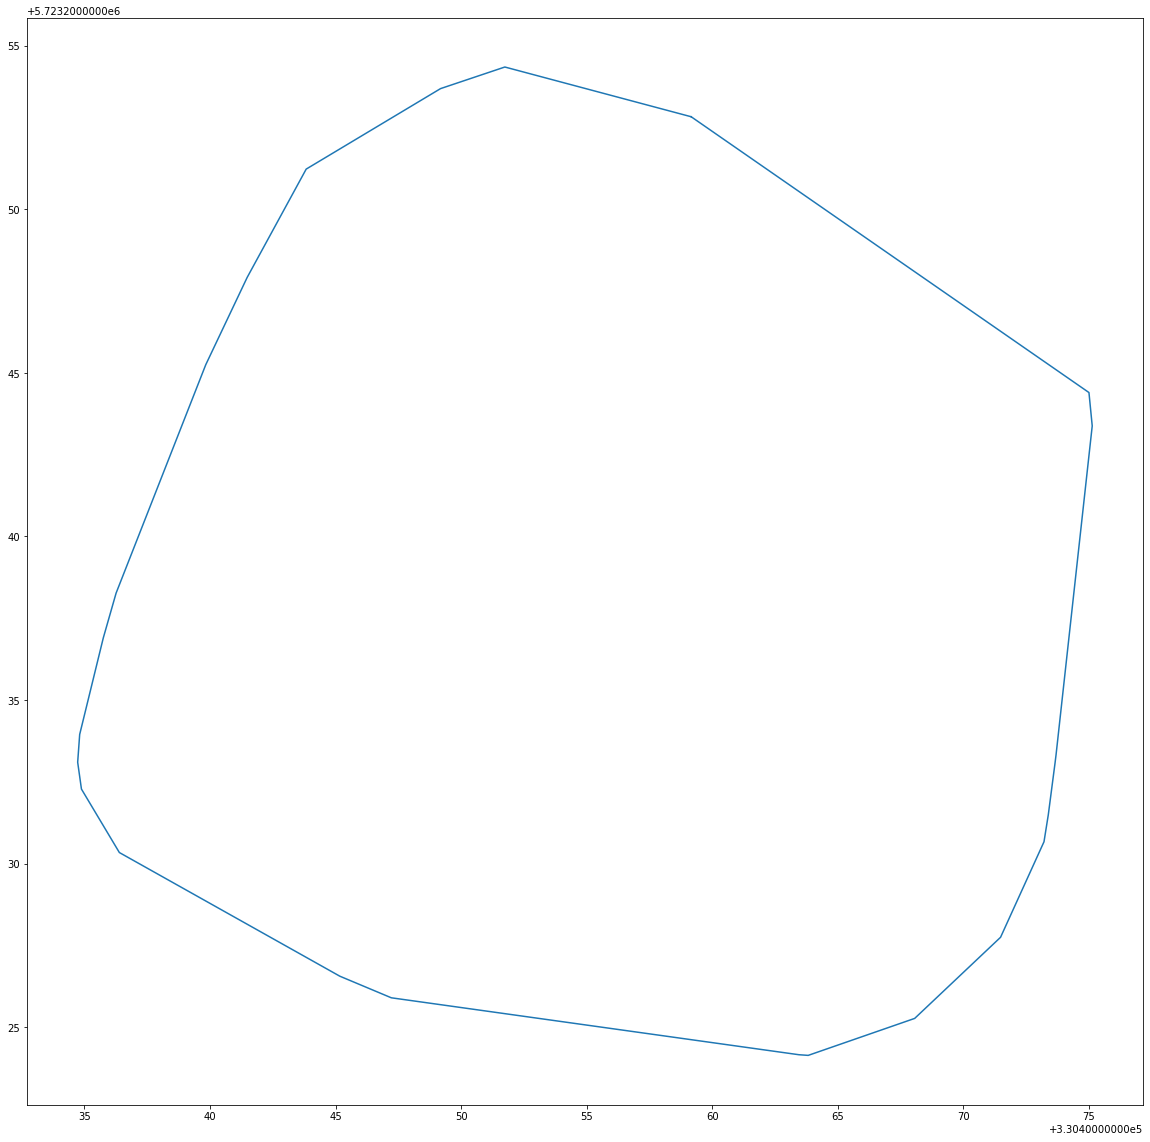

In [57]:
print(hull_dict[1])
x,y = hull_dict[1].exterior.xy
plt.plot(x,y)
plt.show()

In [58]:
import geopandas
# x und y zusammenfassen!
#dann:
trees['coords'] = numpy.array(zip(trees['X'],trees['Y']))
trees['coords'] = trees['coords'].apply(Point)
trees_df = geopandas.GeoDataFrame(trees, geometry='coords', crs="EPSG:25832")
print(trees)
hulls_df = pandas.DataFrame({'INDEX': hull_dict.keys(), 'coords': hull_dict.values()})
hulls_df = geopandas.GeoDataFrame(hulls_df, geometry='coords', crs="EPSG:25832")
print(hulls_df)

           ID              X             Y  STADT  GATTUNG  LIDAR_FILE  \
0       95457  335523.956445  5.725867e+06      3       81         110   
1       95459  335535.470698  5.725857e+06      3       81         110   
2       95462  335546.366808  5.725998e+06      3      116         110   
3       95466  335450.078541  5.725559e+06      3       81         110   
4       95475  335368.800534  5.725561e+06      3       81         110   
...       ...            ...           ...    ...      ...         ...   
13791  109236  337347.729951  5.729250e+06      3       81         132   
13792  109237  337350.323836  5.729248e+06      3       81         132   
13793  109241  339991.201210  5.726174e+06      3       80         145   
13794  109248  336207.601064  5.727646e+06      3       81         121   
13795  109251  336213.639298  5.727666e+06      3       81         121   

                               coords  
0      POINT (335523.956 5725866.986)  
1      POINT (335535.471 572585

<AxesSubplot:>

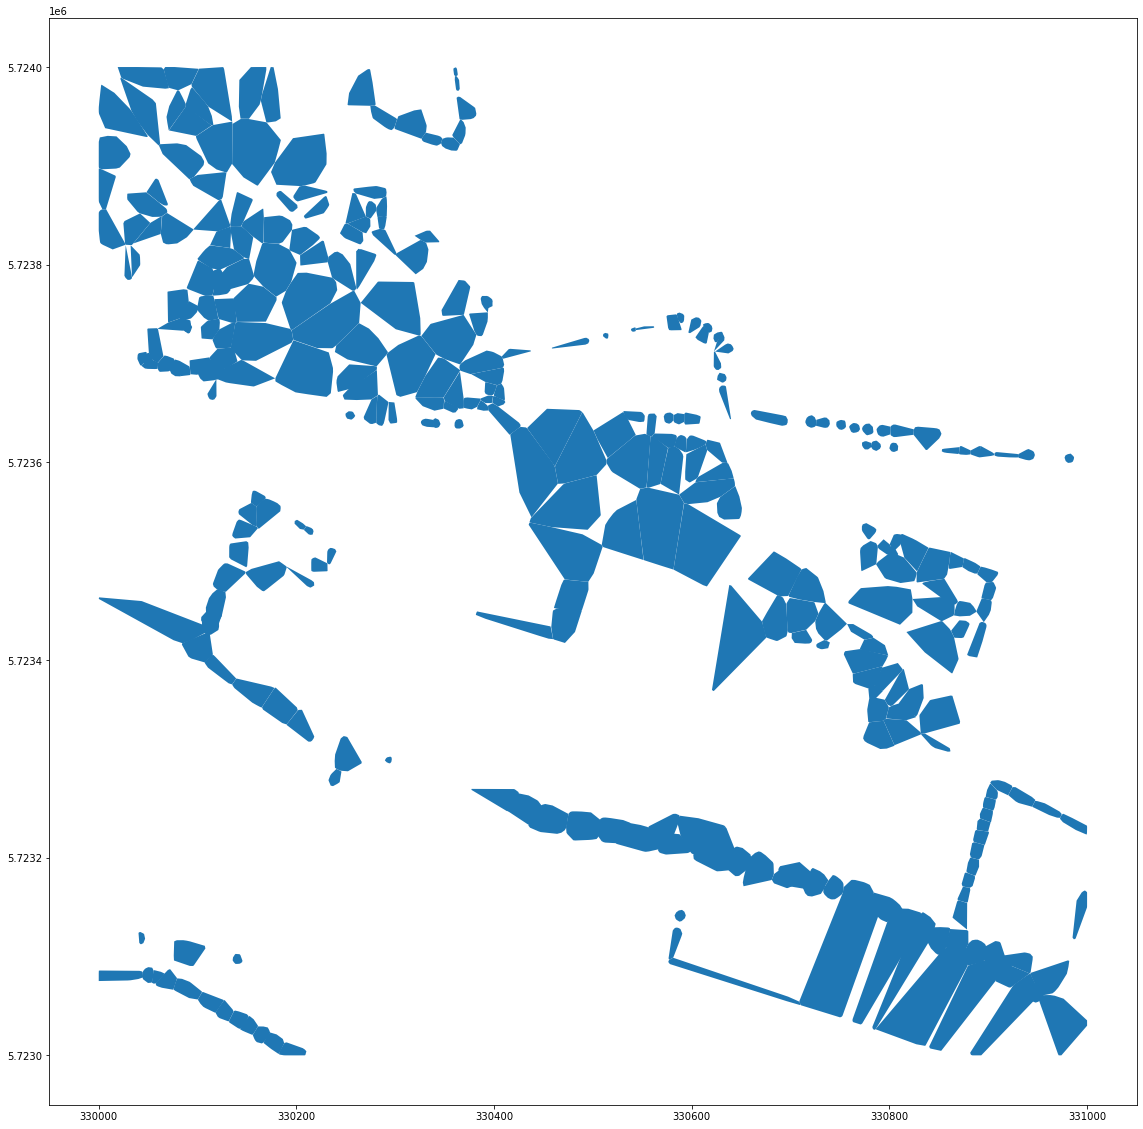

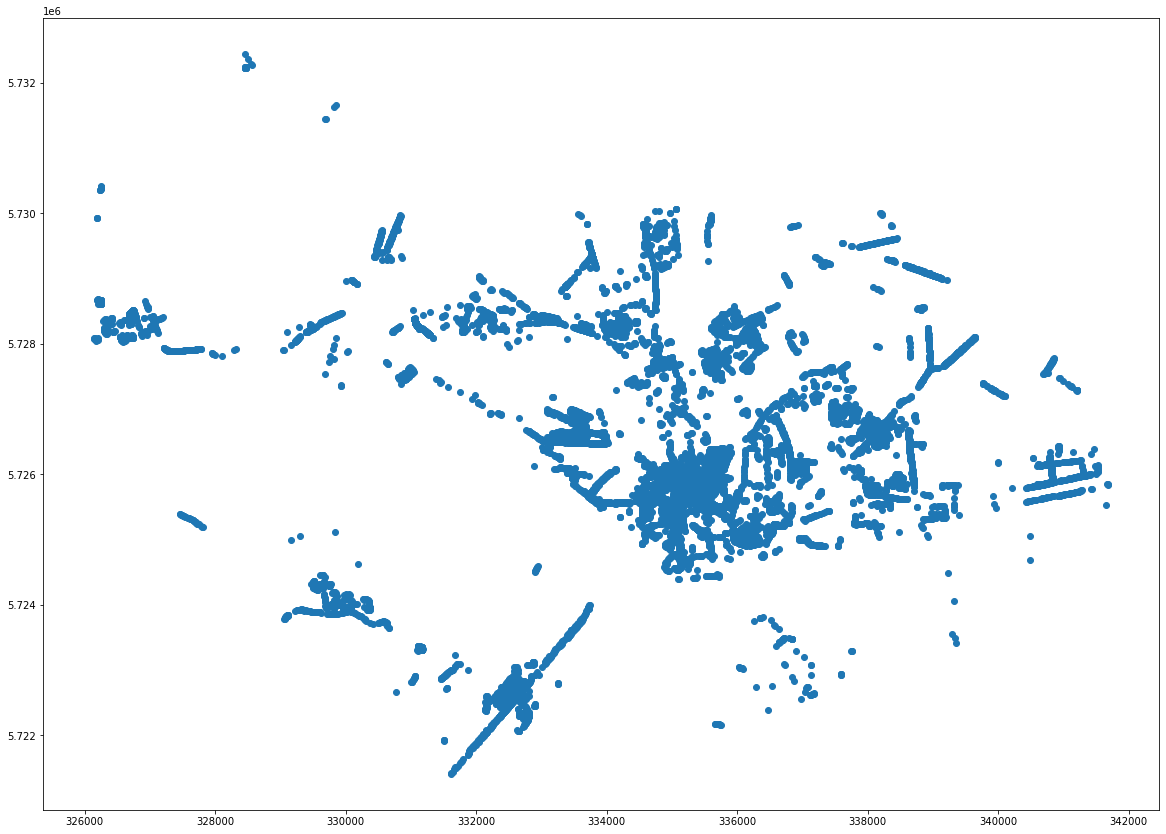

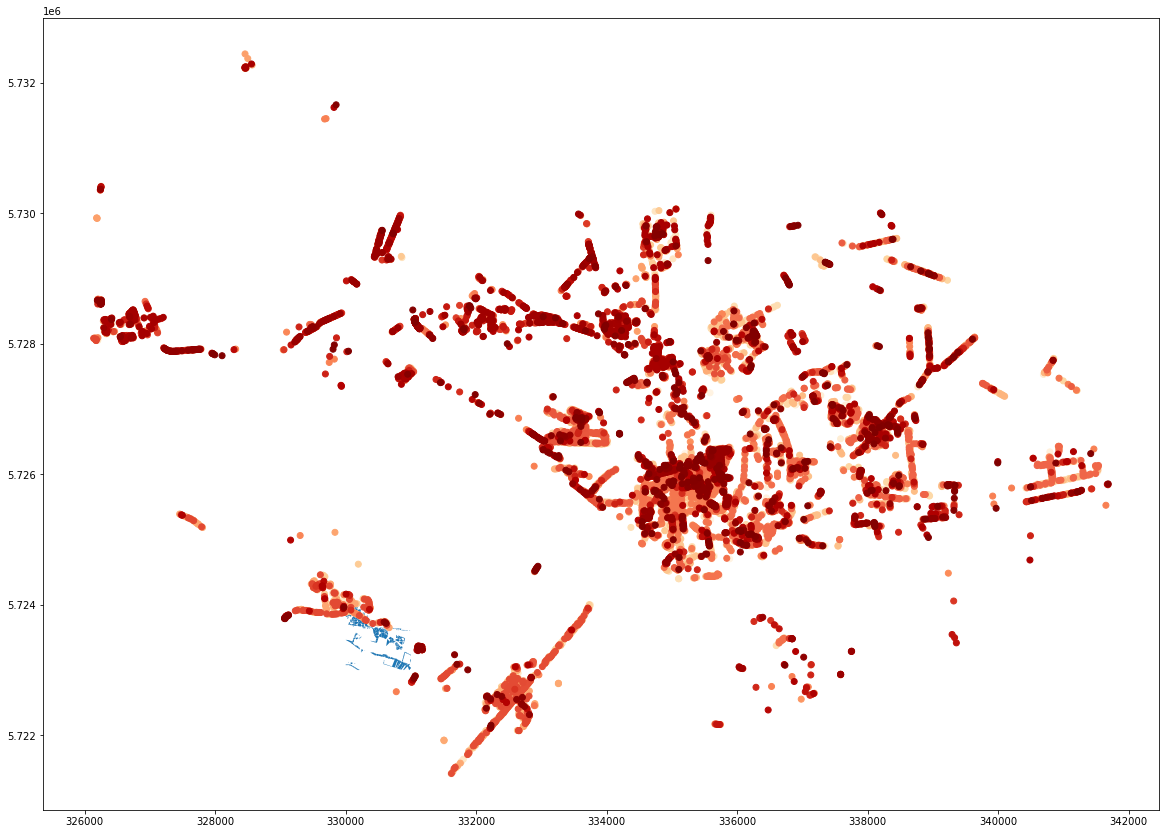

In [70]:
hulls_df.plot()
trees_df.plot()
ax = hulls_df.plot()
trees_df.plot(ax=ax,cmap='OrRd')

           ID              X             Y  STADT  GATTUNG  LIDAR_FILE  \
1811   102894  330615.499578  5.723735e+06      3      116          57   
1812   102895  330627.873782  5.723726e+06      3      116          57   
1812   102895  330627.873782  5.723726e+06      3      116          57   
1813   102898  330662.923406  5.723650e+06      3      116          57   
5930   102897  330665.971401  5.723650e+06      3      116          57   
...       ...            ...           ...    ...      ...         ...   
10504  107467  330598.676458  5.723731e+06      3        2          57   
9500   102900  330630.155909  5.723687e+06      3      116          57   
9502   102909  330541.427048  5.723734e+06      3        2          57   
9503   102912  330415.413573  5.723713e+06      3        2          57   
9550   103094  330276.437560  5.723964e+06      3       81          57   

                               coords  index_right  INDEX  
1811   POINT (330615.500 5723735.326)          136 

<AxesSubplot:>

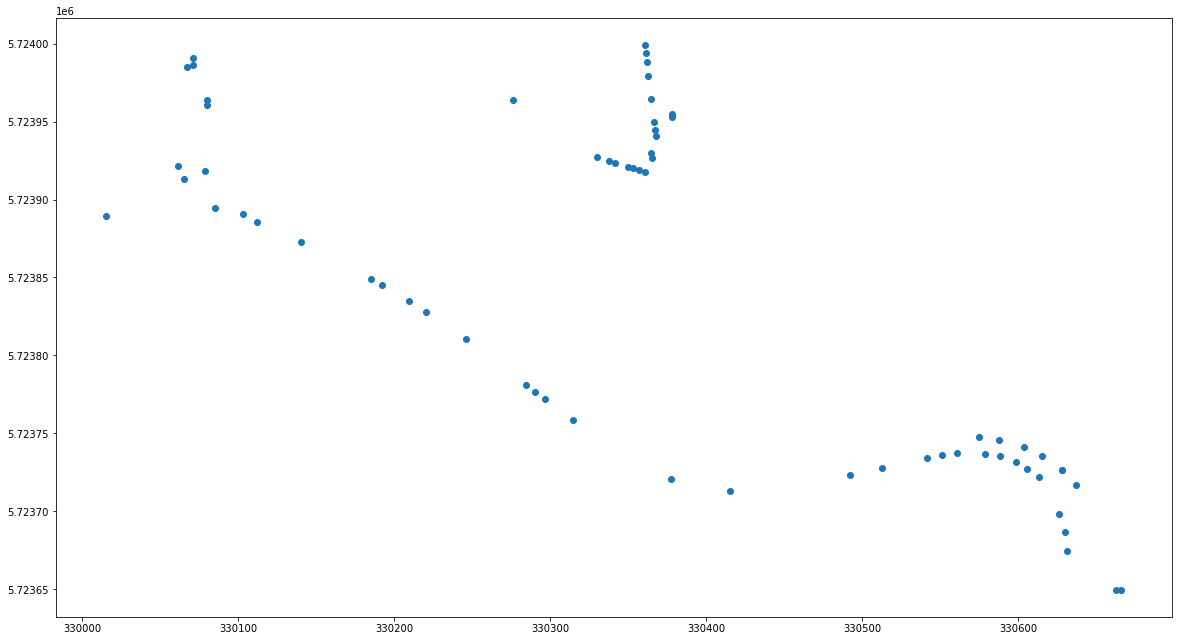

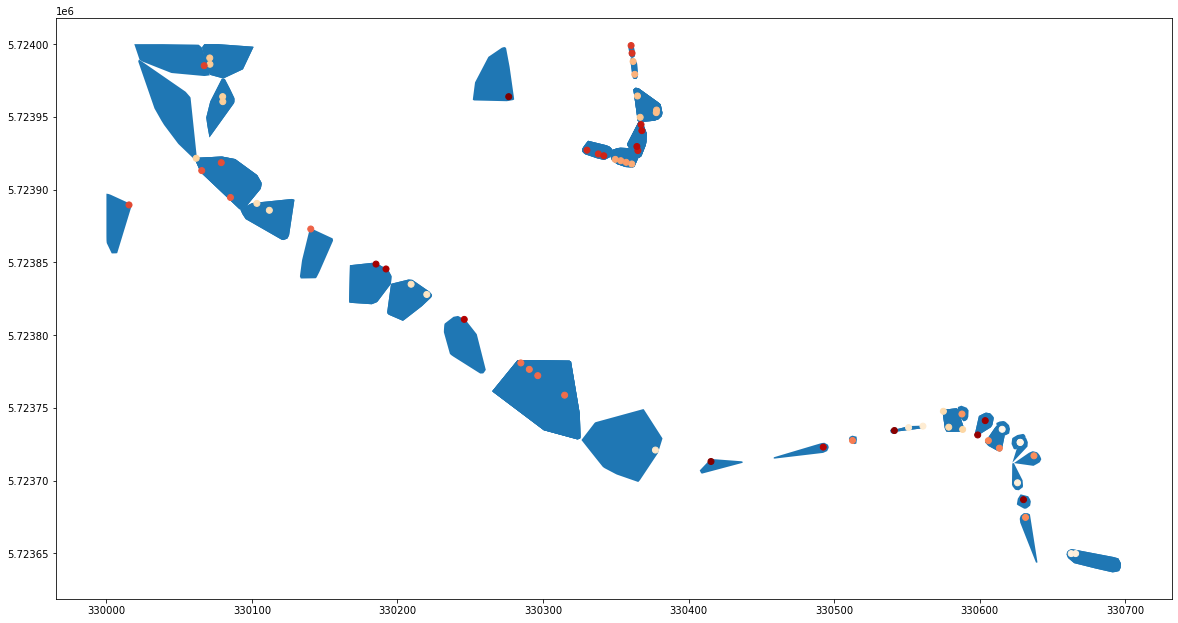

In [74]:
# map to kataster
intersections = geopandas.tools.sjoin( trees_df,hulls_df, op="intersects", how='inner') #intersects
intersections2 = geopandas.tools.sjoin(hulls_df, trees_df, op="intersects", how='inner')

print(intersections)

intersections.plot()

ax = intersections2.plot()
intersections.plot(ax=ax,cmap='OrRd')

In [ ]:
#scale 0:1

In [ ]:
#save